In [200]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [194]:
# BASE DATAFRAMES

# read csv files (need stats from previous season)
df_24_res = pd.read_csv('season results/2023-24 season results.csv')
df_23_stat = pd.read_csv('season stats csv/2022-23 season stats.csv')

# clean stats df 
# --> remove current column headings and replace with row 1
df_23_stat.columns = df_23_stat.iloc[0]
df_23_stat = df_23_stat.drop(0).reset_index(drop = True)

# --> rename columns
df_23_stat = df_23_stat.rename(columns = {'Unnamed: 1_level_1': 'Team'})

# --> remove '*' from team names
df_23_stat['Team'] = df_23_stat['Team'].str.replace('*', '', regex = False)

# --> convert to numeric
df_23_stat[['Rk', 'AvAge', 'GP', 'W', 'L', 'OL', 'PTS', 'PTS%', 'GF', 'GA',
       'SOW', 'SOL', 'SRS', 'SOS', 'GF/G', 'GA/G', 'PP', 'PPO', 'PP%', 'PPA',
       'PPOA', 'PK%', 'SH', 'SHA', 'PIM/G', 'oPIM/G', 'S', 'S%', 'SA', 'SV%',
       'SO']] = df_23_stat[['Rk', 'AvAge', 'GP', 'W', 'L', 'OL', 'PTS', 'PTS%', 'GF', 'GA',
       'SOW', 'SOL', 'SRS', 'SOS', 'GF/G', 'GA/G', 'PP', 'PPO', 'PP%', 'PPA',
       'PPOA', 'PK%', 'SH', 'SHA', 'PIM/G', 'oPIM/G', 'S', 'S%', 'SA', 'SV%',
       'SO']].apply(pd.to_numeric, errors='coerce')

In [164]:
# teams
can_teams = ['Montreal Canadiens', 'Toronto Maple Leafs', 'Vancouver Canucks',
             'Calgary Flames', 'Edmonton Oilers', 'Ottawa Senators',
             'Winnipeg Jets']

atl_div = ['Toronto Maple Leafs', 'Florida Panthers', 'Tampa Bay Lightning',
           'Detroit Red Wings', 'Ottowa Senators', 'Boston Bruins',
           'Montreal Canadiens', 'Buffalo Sabres']

met_div = ['Carolina Hurricanes', 'New Jersey Devils', 'New York Rangers',
           'New York Islanders', 'Pittsburgh Penguins', 'Washington Capitals',
           'Philadelphia Flyers', 'Columbus Blue Jackets']

cen_div = ['Colorado Avalanche', 'Dallas Stars', 'Winnipeg Jets',
           'Minnesota Wild', 'Nashville Predators', 'St. Louis Blues',
           'Arizona Coyotes', 'Chicago Blackhawks']

pac_div = ['Vegas Golden Knights', 'Edmonton Oilers', 'Los Angeles Kings',
           'Seattle Kraken', 'Calgary Flames', 'Vancouver Canucks',
           'San Jose Sharks', 'Anaheim Ducks']

team_to_division = {
    'Toronto Maple Leafs': 'atl', 'Florida Panthers': 'atl', 'Tampa Bay Lightning': 'atl',
    'Detroit Red Wings': 'atl', 'Ottawa Senators': 'atl', 'Boston Bruins': 'atl',
    'Montreal Canadiens': 'atl', 'Buffalo Sabres': 'atl',
    'Carolina Hurricanes': 'met', 'New Jersey Devils': 'met', 'New York Rangers': 'met',
    'New York Islanders': 'met', 'Pittsburgh Penguins': 'met', 'Washington Capitals': 'met',
    'Philadelphia Flyers': 'met', 'Columbus Blue Jackets': 'met',
    'Colorado Avalanche': 'cen', 'Dallas Stars': 'cen', 'Winnipeg Jets': 'cen',
    'Minnesota Wild': 'cen', 'Nashville Predators': 'cen', 'St. Louis Blues': 'cen',
    'Arizona Coyotes': 'cen', 'Chicago Blackhawks': 'cen',
    'Vegas Golden Knights': 'pac', 'Edmonton Oilers': 'pac', 'Los Angeles Kings': 'pac',
    'Seattle Kraken': 'pac', 'Calgary Flames': 'pac', 'Vancouver Canucks': 'pac',
    'San Jose Sharks': 'pac', 'Anaheim Ducks': 'pac'
}

In [163]:
# variables --> put all info in new df
# test with just the 2023-24 season just for now cause i need to figure out
# how eactly to parse all the information and store it correctly

# leafs first

# leafs home games
leafs_df = df_24_res.copy()[df_24_res['Home'] == 'Toronto Maple Leafs']

# cleanup
# make sure attendance is numeric
leafs_df['Attendance'] = pd.to_numeric(leafs_df['Attendance'], errors = 'coerce')

# games with notes (specialty games) --> remove these entries cause they'll just mess up the data
leafs_notes = leafs_df[leafs_df['Notes'].notna() & (leafs_df['Notes'] != '')]
leafs_df = leafs_df.drop(leafs_notes.index)

# games with wack attendance
# 2022 season still partly affected by COVID-19 --> remove these entries cause they'll just mess up the data
leafs_weird_att = leafs_df[(leafs_df['Attendance'] >= 25000) | (leafs_df['Attendance'] <= 18000) | (leafs_df['Attendance'].isna())]
leafs_df = leafs_df.drop(leafs_weird_att.index)

# re-index
leafs_df = leafs_df.reset_index(drop=True)

# make new df with desired variables
df_24_leafs = pd.DataFrame()

# attendance
df_24_leafs['A'] = leafs_df['Attendance']

# when looking at leafs only games, home team stats don't necessarily matter
# stats all previous season --> for now don't change
# can be considered part of the intercept

# visiting team
df_24_leafs['V'] = leafs_df['Visitor']

# visiting team number of games won last season
df_24_leafs['VW'] = df_24_leafs['V'].map(df_23_stat.set_index('Team')['W'])

# visiting team previous season rank diff from leafs
leafs_rk = 5 # can probably do this non-hardcoded
df_24_leafs['VDRk'] = leafs_rk - df_24_leafs['V'].map(df_23_stat.set_index('Team')['Rk'])

# visiting team goals scored
df_24_leafs['VGF'] = df_24_leafs['V'].map(df_23_stat.set_index('Team')['GF'])

# visiting team previous season penalty minutes
df_24_leafs['VPIM'] = df_24_leafs['V'].map(df_23_stat.set_index('Team')['PIM/G']) * 82

# visiting team canadian team dummy (1 - canadian, 0 - otherwise)
df_24_leafs['VCAN'] = df_24_leafs['V'].apply(lambda x: 1 if x in can_teams else 0)

# visiting team division game dummy (1 - in division, 0 - otherwise)
df_24_leafs['VDIV'] = df_24_leafs['V'].apply(lambda x: 1 if x in atl_div else 0)

# weekend vs. weekday dummy (1 - weekend, 0 - otherwise)
# 5/6 are weekend days
df_24_leafs['DAY'] = leafs_df['Day'].isin(['Saturday', 'Sunday']).astype(int)

# log attendance
df_24_leafs['LA'] = np.log(df_24_leafs['A'])

In [134]:
model = smf.ols('LA ~ VW + VDRk + VGF + VPIM + VCAN + VDIV + DAY', data = df_24_leafs).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     LA   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     4.282
Date:                Mon, 24 Feb 2025   Prob (F-statistic):            0.00183
Time:                        21:29:40   Log-Likelihood:                 122.55
No. Observations:                  41   AIC:                            -229.1
Df Residuals:                      33   BIC:                            -215.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9011      0.055    179.777      0.000       9.789      10.013
VW            -0.0007      0.001     -0.714      0.480      -0.003       0.001
VDRk           0.0012      0.001      1.242      0.223      -0.001       0.003
VGF           -0.0001      0.000     -0.924      0.362      -0.000       0.000
VPIM       -1.509e-08   1.79e-05     -0.001      0.999   -3.64e-05    3.64e-05
VCAN           0.0174      0.006      2.756      0.009       0.005       0.030
VDIV           0.0060      0.007      0.897      0.376      -0.008       0.020
DAY            0.0201      0.005      4.242      0.000       0.010       0.030
==============================================================================
Omnibus:                        3.408   Durbin-Watson:                   1.566
Prob(Omnibus):                  0.182   Jarque-Bera (JB):                2.418
Skew:                           0.576   Prob(JB):                        0.299
Kurtosis:                       3.294   Cond. No.                     2.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [135]:
model = smf.ols('LA ~ VCAN + DAY', data = df_24_leafs).fit()

model.summary()

'''
from sklearn.linear_model import LinearRegression

X = df[['VW', 'VDRk', 'VGF']]
y = df['target_variable']

model = LinearRegression()
model.fit(X, y)

print(model.coef_, model.intercept_)
'''

"\nfrom sklearn.linear_model import LinearRegression\n\nX = df[['VW', 'VDRk', 'VGF']]\ny = df['target_variable']\n\nmodel = LinearRegression()\nmodel.fit(X, y)\n\nprint(model.coef_, model.intercept_)\n"

In [173]:
# whole league
# variables --> put all info in new df
# test with just the 2023-24 season just for now cause i need to figure out
# how eactly to parse all the information and store it correctly

# leafs home games
df_24_res_clean = df_24_res.copy()

# cleanup
# make sure attendance is numeric
df_24_res_clean['Attendance'] = pd.to_numeric(df_24_res_clean['Attendance'], errors = 'coerce')

# games with notes (specialty games) --> remove these entries cause they'll just mess up the data
df_notes = df_24_res_clean[df_24_res_clean['Notes'].notna() & (df_24_res_clean['Notes'] != '')]
df_24_res_clean = df_24_res_clean.drop(df_notes.index)

# games with wack attendance
# 2022 season still partly affected by COVID-19 --> remove these entries cause they'll just mess up the data
df_weird_att = df_24_res_clean[(df_24_res_clean['Attendance'] >= 25000) | (df_24_res_clean['Attendance'] <= 18000) | (df_24_res_clean['Attendance'].isna())]
df_24_res_clean = df_24_res_clean.drop(df_weird_att.index)

# re-index
df_24_res_clean = df_24_res_clean.reset_index(drop = True)

#####

# make new df with desired variables
df_24_vars = pd.DataFrame()

# attendance
df_24_vars['A'] = df_24_res_clean['Attendance']

# log attendance
df_24_vars['LA'] = np.log(df_24_vars['A'])

# home team
df_24_vars['H'] = df_24_res_clean['Home']

# visiting team
df_24_vars['V'] = df_24_res_clean['Visitor']

#####

# home team number of games won last season
df_24_vars['HW'] = df_24_vars['H'].map(df_23_stat.set_index('Team')['W'])

# home team previous season rank
df_24_vars['HDRk'] = df_24_vars['H'].map(df_23_stat.set_index('Team')['Rk'])

# home team goals scored
df_24_vars['HGF'] = df_24_vars['H'].map(df_23_stat.set_index('Team')['GF'])

# home team goals allowed
df_24_vars['HGA'] = df_24_vars['H'].map(df_23_stat.set_index('Team')['GA'])

# home team previous season penalty minutes
df_24_vars['HPIM'] = df_24_vars['H'].map(df_23_stat.set_index('Team')['PIM/G']) * 82

# home team canadian team dummy (1 - canadian, 0 - otherwise)
df_24_vars['HCAN'] = df_24_vars['H'].apply(lambda x: 1 if x in can_teams else 0)

#####

# visiting team number of games won last season
df_24_vars['VW'] = df_24_vars['V'].map(df_23_stat.set_index('Team')['W'])

# visiting team previous season rank
df_24_vars['VDRk'] = df_24_vars['V'].map(df_23_stat.set_index('Team')['Rk'])

# visiting team goals scored
df_24_vars['VGF'] = df_24_vars['V'].map(df_23_stat.set_index('Team')['GF'])

# visiting team goals allowed
df_24_vars['VGA'] = df_24_vars['V'].map(df_23_stat.set_index('Team')['GA'])

# visiting team previous season penalty minutes
df_24_vars['VPIM'] = df_24_vars['V'].map(df_23_stat.set_index('Team')['PIM/G']) * 82

# visiting team canadian team dummy (1 - canadian, 0 - otherwise)
df_24_vars['VCAN'] = df_24_vars['V'].apply(lambda x: 1 if x in can_teams else 0)

# weekend vs. weekday dummy (1 - weekend, 0 - otherwise)
# 5/6 are weekend days
df_24_vars['DAY'] = df_24_res_clean['Day'].isin(['Saturday', 'Sunday']).astype(int)

##### try for all days dummy vars

# monday dummy (1 - weekend, 0 - otherwise)
df_24_vars['MDAY'] = df_24_res_clean['Day'].isin(['Monday']).astype(int)

# tuesday dummy (1 - weekend, 0 - otherwise)
df_24_vars['TDAY'] = df_24_res_clean['Day'].isin(['Tuesday']).astype(int)

# wednesday dummy (1 - weekend, 0 - otherwise)
df_24_vars['WDAY'] = df_24_res_clean['Day'].isin(['Wednesday']).astype(int)

# thursday dummy (1 - weekend, 0 - otherwise)
df_24_vars['ThDAY'] = df_24_res_clean['Day'].isin(['Thursday']).astype(int)

# friday dummy (1 - weekend, 0 - otherwise)
df_24_vars['FDAY'] = df_24_res_clean['Day'].isin(['Friday']).astype(int)

# saturday dummy (1 - weekend, 0 - otherwise)
df_24_vars['SDAY'] = df_24_res_clean['Day'].isin(['Saturday']).astype(int)

# sunday dummy (1 - weekend, 0 - otherwise)
df_24_vars['SuDAY'] = df_24_res_clean['Day'].isin(['Sunday']).astype(int)

# in-division game
df_24_vars['DIV'] = df_24_vars.apply(
    lambda row: 1 if team_to_division.get(row['H']) == team_to_division.get(row['V']) else 0, axis=1
)

In [174]:
df_24_vars

,A,LA,H,V,HW,HDRk,HGF,HGA,HPIM,HCAN,...,VCAN,DAY,MDAY,TDAY,WDAY,ThDAY,FDAY,SDAY,SuDAY,DIV
0,18411,9.820704,Pittsburgh Penguins,Chicago Blackhawks,40,20.0,261,263,705.2,0,...,0,0,0,1,0,0,0,0,0,0
1,19092,9.857025,Tampa Bay Lightning,Nashville Predators,46,13.0,280,252,992.2,0,...,0,0,0,1,0,0,0,0,0,0
2,18724,9.837561,Vegas Golden Knights,Seattle Kraken,51,4.0,267,225,590.4,0,...,0,0,0,1,0,0,0,0,0,1
3,18893,9.846547,Carolina Hurricanes,Ottawa Senators,52,2.0,262,210,615.0,0,...,1,0,0,0,1,0,0,0,0,0
4,18145,9.806150,Los Angeles Kings,Colorado Avalanche,47,10.0,274,254,705.2,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,19092,9.857025,Tampa Bay Lightning,Toronto Maple Leafs,46,13.0,280,252,992.2,0,...,1,0,0,0,1,0,0,0,0,1
727,18129,9.805268,Colorado Avalanche,Edmonton Oilers,51,6.0,274,223,672.4,0,...,1,0,0,0,0,1,0,0,0,0
728,18145,9.806150,Los Angeles Kings,Chicago Blackhawks,47,10.0,274,254,705.2,0,...,0,0,0,0,0,1,0,0,0,0
729,19138,9.859431,Minnesota Wild,Seattle Kraken,46,11.0,239,219,926.6,0,...,0,0,0,0,0,1,0,0,0,0


In [176]:
model = smf.ols('LA ~ HW + HDRk + HGF + HGA + HPIM + HCAN + VW + VDRk + VGF + VGA + VPIM + VCAN + DAY + DIV', data = df_24_vars).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     LA   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     59.38
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          1.17e-109
Time:                        13:20:29   Log-Likelihood:                 1627.8
No. Observations:                 731   AIC:                            -3226.
Df Residuals:                     716   BIC:                            -3157.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.8207      0.045    218.632      0.000       9.733       9.909
HW             0.0007      0.001      0.830      0.407      -0.001       0.002
HDRk        -1.68e-05      0.001     -0.022      0.982      -0.002       0.001
HGF           -0.0007   7.77e-05     -8.696      0.000      -0.001      -0.001
HGA            0.0002   8.54e-05      1.846      0.065   -9.97e-06       0.000
HPIM           0.0001   8.46e-06     13.053      0.000    9.39e-05       0.000
HCAN           0.0330      0.003     12.650      0.000       0.028       0.038
VW             0.0006      0.000      1.349      0.178      -0.000       0.001
VDRk           0.0004      0.000      0.915      0.360      -0.000       0.001
VGF        -1.166e-05   7.34e-05     -0.159      0.874      -0.000       0.000
VGA         2.735e-05   7.62e-05      0.359      0.720      -0.000       0.000
VPIM       -2.207e-06   8.43e-06     -0.262      0.794   -1.88e-05    1.43e-05
VCAN           0.0020      0.002      0.797      0.426      -0.003       0.007
DAY            0.0015      0.002      0.732      0.465      -0.002       0.005
DIV           -0.0004      0.002     -0.175      0.861      -0.004       0.004
==============================================================================
Omnibus:                        6.902   Durbin-Watson:                   2.204
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                6.909
Skew:                           0.238   Prob(JB):                       0.0316
Kurtosis:                       3.015   Cond. No.                     5.46e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [178]:
model = smf.ols('LA ~ HGF + HPIM + HCAN', data = df_24_vars).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     LA   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     274.7
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          3.75e-119
Time:                        13:21:02   Log-Likelihood:                 1623.1
No. Observations:                 731   AIC:                            -3238.
Df Residuals:                     727   BIC:                            -3220.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9043      0.012    821.855      0.000       9.881       9.928
HGF           -0.0006   3.74e-05    -16.146      0.000      -0.001      -0.001
HPIM           0.0001   7.57e-06     14.857      0.000    9.76e-05       0.000
HCAN           0.0341      0.002     14.497      0.000       0.030       0.039
==============================================================================
Omnibus:                        7.867   Durbin-Watson:                   2.221
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                7.782
Skew:                           0.234   Prob(JB):                       0.0204
Kurtosis:                       3.193   Cond. No.                     9.94e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [169]:
model = smf.ols('A ~ HW + HDRk + HGF + HPIM + HCAN + VW + VDRk + VGF + VPIM + VCAN + DAY + DIV', data = df_24_vars).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      A   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     69.13
Date:                Mon, 24 Feb 2025   Prob (F-statistic):          4.32e-111
Time:                        21:45:17   Log-Likelihood:                -5589.1
No. Observations:                 731   AIC:                         1.120e+04
Df Residuals:                     718   BIC:                         1.126e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.885e+04    804.358     23.431      0.000    1.73e+04    2.04e+04
HW            15.3242     16.526      0.927      0.354     -17.122      47.770
HDRk          13.7431     12.923      1.063      0.288     -11.628      39.114
HGF          -12.1215      1.378     -8.799      0.000     -14.826      -9.417
HPIM           2.0616      0.162     12.735      0.000       1.744       2.379
HCAN         672.8267     48.683     13.821      0.000     577.248     768.405
VW             9.1706      7.287      1.259      0.209      -5.135      23.477
VDRk           7.6239      7.385      1.032      0.302      -6.874      22.122
VGF            0.1385      1.062      0.130      0.896      -1.947       2.224
VPIM          -0.0416      0.163     -0.255      0.799      -0.362       0.279
VCAN          35.5951     48.183      0.739      0.460     -59.002     130.192
DAY           24.2483     38.943      0.623      0.534     -52.208     100.705
DIV           -5.7680     40.131     -0.144      0.886     -84.556      73.020
==============================================================================
Omnibus:                       10.821   Durbin-Watson:                   2.221
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               10.859
Skew:                           0.284   Prob(JB):                      0.00439
Kurtosis:                       3.182   Cond. No.                     4.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [172]:
model = smf.ols('A ~ HW + HDRk + HGF + HPIM + HCAN + VW + VDRk + VGF + VPIM + VCAN + MDAY + TDAY + WDAY + ThDAY + FDAY + SDAY + SuDAY + DIV', data = df_24_vars).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      A   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     49.43
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          3.02e-108
Time:                        13:18:44   Log-Likelihood:                -5585.1
No. Observations:                 731   AIC:                         1.121e+04
Df Residuals:                     713   BIC:                         1.129e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.635e+04    709.183     23.059      0.000     1.5e+04    1.77e+04
HW            17.2853     16.572      1.043      0.297     -15.251      49.821
HDRk          14.8589     12.944      1.148      0.251     -10.554      40.272
HGF          -12.2585      1.383     -8.864      0.000     -14.974      -9.543
HPIM           2.0663      0.162     12.734      0.000       1.748       2.385
HCAN         680.1873     48.944     13.897      0.000     584.096     776.278
VW             9.5382      7.307      1.305      0.192      -4.807      23.883
VDRk           8.6833      7.416      1.171      0.242      -5.877      23.244
VGF            0.3689      1.065      0.346      0.729      -1.722       2.460
VPIM          -0.0437      0.163     -0.267      0.789      -0.364       0.277
VCAN          32.8249     48.166      0.681      0.496     -61.739     127.389
MDAY        2215.5983    119.229     18.583      0.000    1981.516    2449.681
TDAY        2321.1644    112.316     20.666      0.000    2100.655    2541.673
WDAY        2319.6516    119.695     19.380      0.000    2084.654    2554.649
ThDAY       2346.7536    111.162     21.111      0.000    2128.510    2564.998
FDAY        2461.7366    112.699     21.844      0.000    2240.476    2682.997
SDAY        2369.7288    108.370     21.867      0.000    2156.966    2582.491
SuDAY       2318.1698    113.145     20.489      0.000    2096.033    2540.307
DIV           -0.4647     40.299     -0.012      0.991     -79.583      78.653
==============================================================================
Omnibus:                       12.231   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.364
Skew:                           0.303   Prob(JB):                      0.00207
Kurtosis:                       3.199   Cond. No.                     3.65e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.97e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [183]:
# correlation matrix
corr_matrix = df_24_vars.drop(columns=['H', 'V']).corr()

corr_matrix

,A,LA,HW,HDRk,HGF,HGA,HPIM,HCAN,VW,VDRk,...,VCAN,DAY,MDAY,TDAY,WDAY,ThDAY,FDAY,SDAY,SuDAY,DIV
A,1.000000,0.999621,-0.446470,0.448285,-0.399886,0.408189,0.533857,0.386717,0.052470,-0.042009,...,0.044170,0.072762,-0.081998,0.019389,-0.067360,0.011908,-0.014973,0.082057,-0.007203,-0.012639
LA,0.999621,1.000000,-0.444892,0.446728,-0.398050,0.405255,0.536798,0.384249,0.054130,-0.043439,...,0.045929,0.075211,-0.083385,0.016403,-0.068084,0.011938,-0.013390,0.084842,-0.007484,-0.012481
HW,-0.446470,-0.444892,1.000000,-0.978710,0.764975,-0.856026,-0.241087,-0.036666,-0.053599,0.051205,...,-0.004195,-0.097703,0.055525,0.003669,0.087242,0.034668,-0.033067,-0.055824,-0.076628,-0.012811
HDRk,0.448285,0.446728,-0.978710,1.000000,-0.683661,0.901537,0.305661,0.054079,0.055857,-0.053953,...,0.002225,0.091465,-0.054229,-0.003406,-0.082609,-0.021033,0.017321,0.060090,0.059305,0.013146
HGF,-0.399886,-0.398050,0.764975,-0.683661,1.000000,-0.437523,-0.136042,0.213129,-0.005778,0.003584,...,0.011720,-0.090669,0.051048,0.008254,0.111576,0.006675,-0.031842,-0.013244,-0.132330,0.001098
HGA,0.408189,0.405255,-0.856026,0.901537,-0.437523,1.000000,0.263006,0.217059,0.062423,-0.066358,...,0.003955,0.073524,-0.080180,0.008847,-0.043306,-0.011238,0.003365,0.071636,0.010629,0.019894
HPIM,0.533857,0.536798,-0.241087,0.305661,-0.136042,0.263006,1.000000,0.217736,0.025431,-0.020209,...,0.054142,0.031973,-0.019631,0.021615,-0.063680,0.063313,-0.089194,0.061936,-0.044250,-0.012789
HCAN,0.386717,0.384249,-0.036666,0.054079,0.213129,0.217059,0.217736,1.000000,0.005575,-0.009143,...,0.022356,0.013155,-0.003214,0.068781,0.027885,-0.029264,-0.094681,0.063962,-0.079295,-0.015520
VW,0.052470,0.054130,-0.053599,0.055857,-0.005778,0.062423,0.025431,0.005575,1.000000,-0.956566,...,0.040953,0.004822,0.026605,-0.032037,0.038869,-0.035913,0.015692,0.050678,-0.072301,0.017902
VDRk,-0.042009,-0.043439,0.051205,-0.053953,0.003584,-0.066358,-0.020209,-0.009143,-0.956566,1.000000,...,-0.038190,-0.005713,-0.016095,0.027159,-0.016505,0.028342,-0.031809,-0.042155,0.057262,-0.003087


In [188]:
# correlation with variables that would be expected to be correlated
# home team dependent variables
corr_matrix_H = df_24_vars[['HW', 'HDRk', 'HGF', 'HGA', 'HPIM', 'HCAN']].corr()

print(corr_matrix_H)

# day variables (surprisingly uncorrelated)
corr_matrix_D = df_24_vars[['DAY', 'MDAY', 'TDAY', 'WDAY', 'ThDAY', 'FDAY', 'SDAY', 'SuDAY']].corr()

corr_matrix_D

            HW      HDRk       HGF       HGA      HPIM      HCAN
HW    1.000000 -0.978710  0.764975 -0.856026 -0.241087 -0.036666
HDRk -0.978710  1.000000 -0.683661  0.901537  0.305661  0.054079
HGF   0.764975 -0.683661  1.000000 -0.437523 -0.136042  0.213129
HGA  -0.856026  0.901537 -0.437523  1.000000  0.263006  0.217059
HPIM -0.241087  0.305661 -0.136042  0.263006  1.000000  0.217736
HCAN -0.036666  0.054079  0.213129  0.217059  0.217736  1.000000


,DAY,MDAY,TDAY,WDAY,ThDAY,FDAY,SDAY,SuDAY
DAY,1.000000,-0.246198,-0.322833,-0.262942,-0.407343,-0.237544,0.815801,0.396233
MDAY,-0.246198,1.000000,-0.123668,-0.100725,-0.156041,-0.090996,-0.200849,-0.097552
TDAY,-0.322833,-0.123668,1.000000,-0.132078,-0.204613,-0.119321,-0.263367,-0.127917
WDAY,-0.262942,-0.100725,-0.132078,1.000000,-0.166654,-0.097185,-0.214508,-0.104186
ThDAY,-0.407343,-0.156041,-0.204613,-0.166654,1.000000,-0.150556,-0.332311,-0.161403
FDAY,-0.237544,-0.090996,-0.119321,-0.097185,-0.150556,1.000000,-0.193789,-0.094123
SDAY,0.815801,-0.200849,-0.263367,-0.214508,-0.332311,-0.193789,1.000000,-0.207750
SuDAY,0.396233,-0.097552,-0.127917,-0.104186,-0.161403,-0.094123,-0.207750,1.000000


In [205]:
# select only numeric columns
X = df_24_vars.drop(columns = ['A', 'LA', 'MDAY']).select_dtypes(include = [np.number])

# compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

     HW  HDRk  HGF  HGA   HPIM  HCAN  VW  VDRk  VGF  VGA    VPIM  VCAN  DAY  \
0    40  20.0  261  263  705.2     0  26  30.0  202  299   705.2     0    0   
1    46  13.0  280  252  992.2     0  42  18.0  223  236   787.2     0    0   
2    51   4.0  267  225  590.4     0  46  12.0  289  252   697.0     0    0   
3    52   2.0  262  210  615.0     0  39  21.0  259  270  1016.8     1    0   
4    47  10.0  274  254  705.2     0  51   6.0  274  223   672.4     0    0   
..   ..   ...  ...  ...    ...   ...  ..   ...  ...  ...     ...   ...  ...   
726  46  13.0  280  252  992.2     0  50   5.0  278  220   688.8     1    0   
727  51   6.0  274  223  672.4     0  50   7.0  325  256   705.2     1    0   
728  47  10.0  274  254  705.2     0  26  30.0  202  299   705.2     0    0   
729  46  11.0  239  219  926.6     0  46  12.0  289  252   697.0     0    0   
730  51   4.0  267  225  590.4     0  23  32.0  206  335   926.6     0    0   

     TDAY  WDAY  ThDAY  FDAY  SDAY  SuDAY  DIV  
0 

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,HW,713.320457
1,HDRk,134.720356
2,HGF,404.668070
3,HGA,494.720106
4,HPIM,43.449696
5,HCAN,1.874582
6,VW,301.539414
7,VDRk,59.715987
8,VGF,384.318039
9,VGA,374.676362


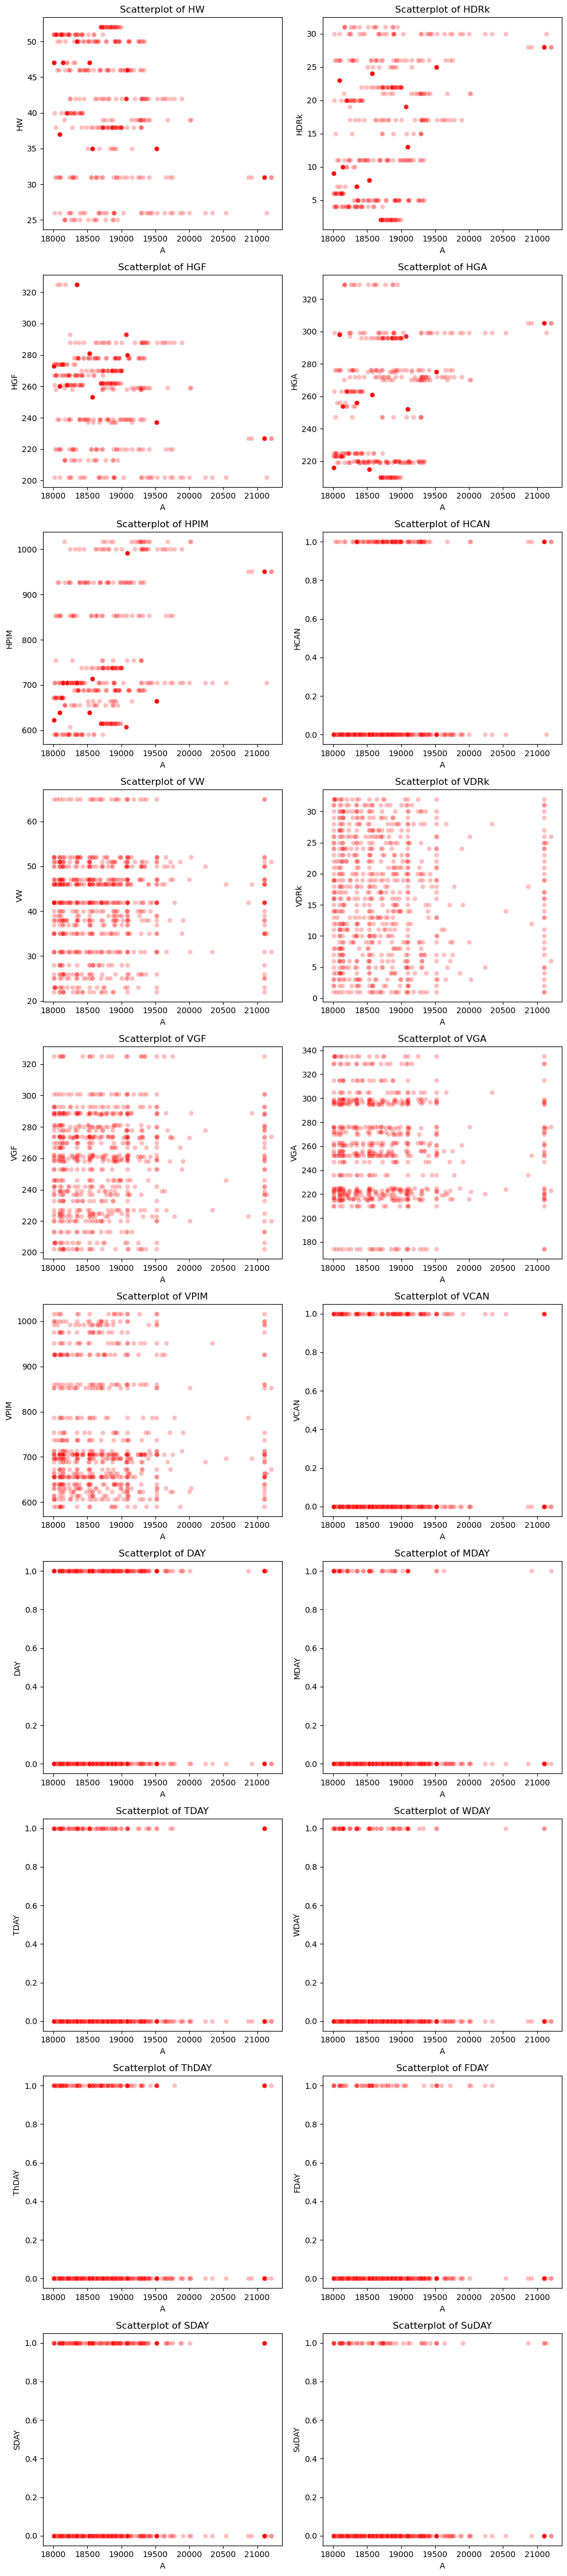

In [214]:
# features to analyze (not A, LA, or non-numeric values)
features = df_24_vars.drop(columns = ['A', 'LA']).select_dtypes(include = [np.number])
features = features.columns.tolist()

# num rows and cols in scatter and boxplots
numrows = 10
numcols = 2

# scatterplots
fig, axes = plt.subplots(nrows = numrows, ncols = numcols, figsize = (10, 45))
for i in range(numrows):
    for j in range(numcols):
        idx = i * numcols + j
        sns.scatterplot(data = df_24_vars, x = 'A', y = features[idx],
                        ax = axes[i, j], color = 'red', alpha = 0.25)
        axes[i, j].set_title(f"Scatterplot of {features[idx]}")
        axes[i, j].set_ylabel(features[idx])
        axes[i, j].set_xlabel('A')

plt.tight_layout()
plt.show()